<a href="https://colab.research.google.com/github/sbistline/model_test/blob/main/Introduction_to_Haliax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Introduction to Haliax with Transformers

Haliax is a JAX library for building neural networks with named tensors, in the tradition of [Tensor Considered Harmful](https://nlp.seas.harvard.edu/NamedTensor). We use named tensors in Levanter to improve the legibility and compositionality of our programs without sacrificing their performance or scalability. We're going to build a simple Transformer for an autoregressive language model, starting from basic Haliax concepts. We'll assume you have some familiarity with Transformers.

This tutorial mainly focuses on the legibility aspects of named tensors as implemented in Haliax. We'll cover scaling, including fully-sharded data parallelism [in the next tutorial](https://colab.research.google.com/drive/1QX4yH3zRFF3Xiibf1aahETcSQ5nbcUMz?usp=sharing).




## Installation

Haliax is available on PyPI, so we install it, along with a few other useful libraries.

In [ ]:
# the pre-installed version of Jax is very old
!pip install -U jax==0.4.10 jaxlib==0.4.10
!pip install haliax==1.0.1
# We use HF in this tutorial for tokenizers and data loading
!pip install transformers zstandard datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.8 MB/s eta 0:00:00


# Named Tensors

## Motivation

The typical way people build neural networks is with an neural net library like PyTorch, Tensorflow, Keras, or, in the Jax world, Flax, Haiku, or Equinox. All of these libraries are mainly centered around organizing n-dimensional arrays into modules, and then doing compute on the parameters and input data.


I get really confused when reading tensor code that uses axes like 0, 1, -1, -2, etc. It's not clear what those axes are, and it's especially unclear when you have multiple tensors with different shapes. I also run into bugs constantly. Take this code:

In [ ]:
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey

# predict y from x using  a linear model (W)
x = jrandom.uniform(PRNGKey(0), (128, 64))
y = jrandom.uniform(PRNGKey(1), (128,))
W = jrandom.uniform(PRNGKey(2), (64, 1))

def mse(pred, target):
    return jnp.mean((pred - target) * (pred - target) )

y_pred = x @ W
mse(y_pred, y)

Array(225.611, dtype=float32)

This code appears straightforward, but it has a bug: the dimensions of `y_pred` and `y` are not the same.
Because `y_pred` is a 2D array of shape `(128, 1)`, and `y` is a 1D array of shape `(128,)`, the `-` operator will broadcast `y` to shape `(128, 128)`.
(This makes the subtraction an "outer product"-like operation rather than the intended elementwise subtraction.)
But, you won't get an error at runtime; this is a silent bug. The `mean` call hides the bug by averaging over all values.

This is a common bug in deep learning code, and it's easy to miss. I have personally lost multiple days to this exact bug over the years,
in every deep learning framework I've used.



So I found Alexander Rush's Tensor Considered Harmful to be very convincing. In particular, he argues that:

* Named axes are more semantically meaningful and rely less on bitrot-prone comments.
* Broadcasting leads to unreadable strings of `views` and `squeezes`. (To this, I'd add implicit broadcasting is a source of bugs.)
* Named axes allow you to abstract over unreferenced dimensions, making code more flexible for things like multi-headed attention or flexible attention masking.

Named arrays are a way to make deep learning code more readable, and more robust. With Haliax, we get these benefits while still maintaining performance and scale. We'll fix this bug after we introduce Haliax.


By using semantically meaningful axes like `Batch` and `Feature`, this code avoids the trap. We'll see how all these pieces work as we go.



## Introducing `Axis`

Despite the notational difficulties in deep learning papers, semantically meaningful dimensions are usually at their core. For example, here is how the Gopher's paper specifies the details of their models:



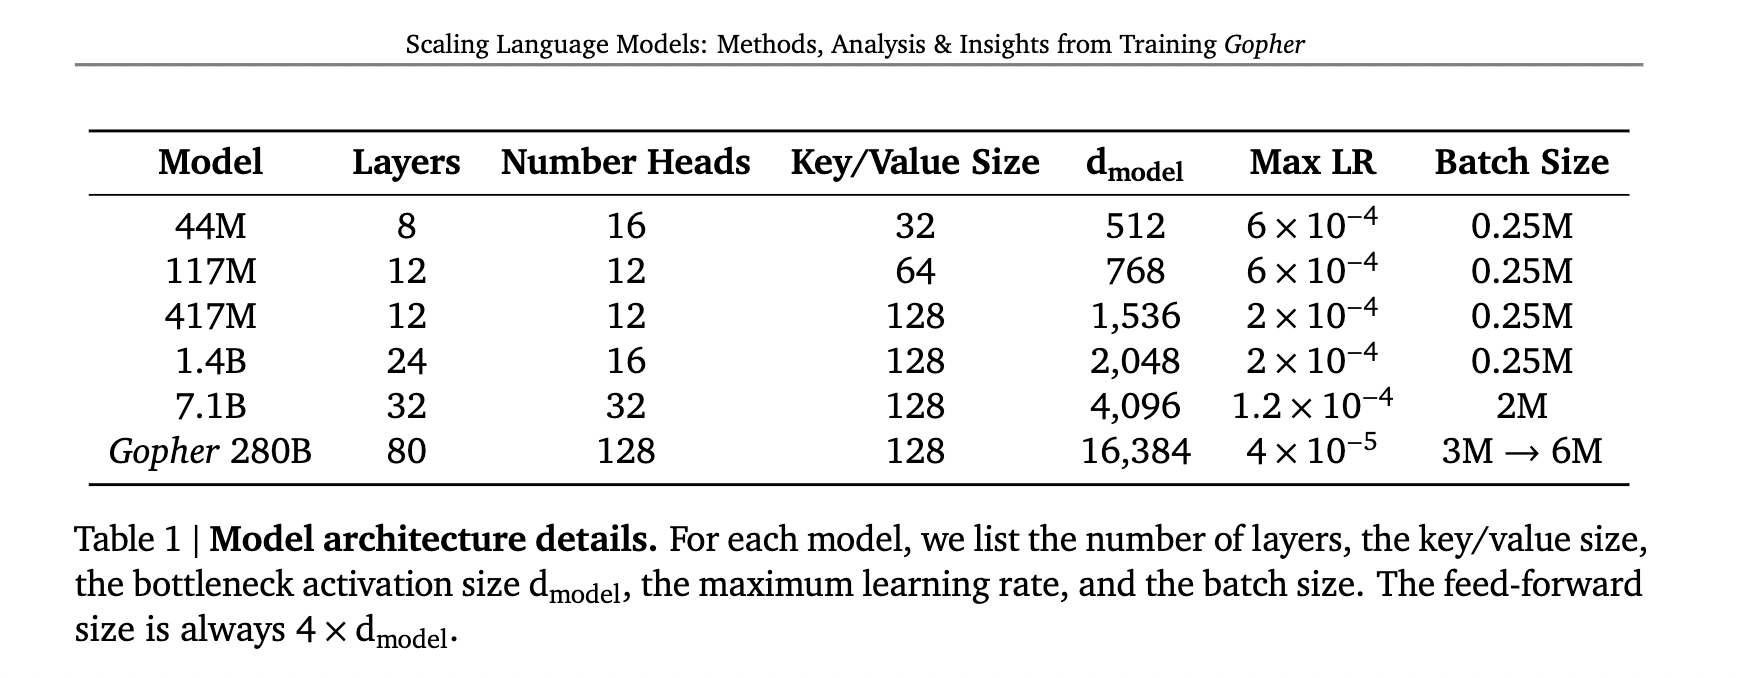

The column names are semantically meaningful: there are 8 "Layers" of transformer blocks, there are 16 "Heads" in each attention computation, etc. What we're going to do is reify those names in code and use them to refer to the relevant parts of our model.

## Haliax's `Axis`

The cornerstone of Haliax's approach to named tensors is the `Axis`, which is a string name and a size. An `Axis` gives both size and meaning to the dimensions of a tensor. In Haliax, we use Capitalized values for Axes to distinguish them from other variables like tensors (like `key` or `embedding`) and indices (like `layer`).

Here is how we can define the Axes for a (very) small Transformer model.

In [ ]:
import haliax as hax  # this amuses me more than it should
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

# smaller versions of the numbers from the above table
Layer = hax.Axis("layer", 4)
Head = hax.Axis("head", 8)
Key = hax.Axis("key", 16)
Embed = hax.Axis("embed", 32)
Mlp = hax.Axis("mlp", Embed.size * 4)  # this is the "feed-forward size", above

# other numbers we need
Batch = hax.Axis("batch", 8)
Pos = hax.Axis("position", 128)  # how long each sequence is
Vocab = hax.Axis("vocab", len(tokenizer))

## Named Arrays

In Haliax, we create named arrays using a syntax that mirrors Jax/NumPy's syntax, except that integer shape specifications are replaced with a tuple of Axes:

In [ ]:
import jax.numpy as jnp

bias = hax.zeros(Mlp)
weight = hax.ones((Embed, Mlp))
word_embedding = hax.zeros((Vocab, Embed))
data = hax.ones((Batch, Pos), dtype=jnp.int32)
layer_indices = hax.arange(Layer)  # 0...Layer.size

### Wrapping "Raw" Arrays

You can also wrap any "raw" Jax array using `haliax.named(array, names)`. `names` can be (a tuple of) string names, or `Axes`, or a mix of the two. `Axis` arguments will be checked to ensure the dimensions of the array are the same as the `Axis`'s size.

In [ ]:
a = jnp.zeros((32, 32 * 4))
named_a = hax.named(a, (Embed, Mlp))
named_a = hax.named(a, ("embed", "mlp"))  # ok, b/c axis sizes can be inferred

In general, you can use string names anywhere the size of the axis can be inferred. We will see this again shortly.

### Random Numbers

In practice, most of our parameters are initialized randomly. We use Jax's random number generation, which means we need to pass around the random number generator's state (the `PRNGKey`) explicitly.

In [ ]:
import jax.random
from jax.random import PRNGKey

base_key = PRNGKey(0)
k_w, k_e, k_d = jax.random.split(base_key, 3)  # keys for each of the generations we do below

weight = hax.random.normal(k_w, (Embed, Mlp))
word_embedding = hax.random.normal(k_e, (Vocab, Embed))
data = hax.random.randint(k_d, (Batch, Pos), 0, Vocab.size)  # samples from [0, Vocab)

## Operations on NamedArrays

Most "elementwise" (e.g. addition, or `relu`) and "reduction" (e.g. `mean`, `sum`) operations are defined very similarly to normal Jax/NumPy, with identical names. Axis arguments are typically replaced with their named equivalents:

In [ ]:
_ = bias + bias
_ = hax.sin(bias)
_ = hax.nn.relu(bias)

m_weight = hax.mean(weight, Embed)
m_weight = hax.mean(weight, "embed")  # also ok
total = hax.sum(weight, (Embed, Mlp))  # equivalent to hax.sum(weight)

### Broadcasting

One area where Haliax's treatment of named axes differs substantially from NumPy-esque positional code is in broadcasting. In traditional positional code, [broadcasting works like this](https://numpy.org/doc/stable/user/basics.broadcasting.html):

In [ ]:
import numpy as np

# compute the outer product of two arrays
a = np.arange(5)
b = np.arange(4)

c = a.reshape((-1, 1)) * b.reshape((1, -1))
print(c.shape)
print(c)

# alternatively
c2 = a[:, np.newaxis] * b

(5, 4)
[[ 0  0  0  0]
 [ 0  1  2  3]
 [ 0  2  4  6]
 [ 0  3  6  9]
 [ 0  4  8 12]]


To quote the NumPy documentation, for positional arrays, "in order to broadcast, the size of the trailing axes for both arrays in an operation must either be the same size or one of them must be one."

I have found this to be a source of bugs: it is easy to accidentally have an array of size `[batch_size, 1]` and combine it with an array of size `[batch_size]`, yielding an array of `[batch_size, batch_size]`.

In Haliax, broadcasting is done by matching names. The same operation in Haliax might look like this:



In [ ]:
M = hax.Axis("M", 5)
N = hax.Axis("N", 4)

a = hax.arange(M)
b = hax.arange(N)

c = a.broadcast_axis(N) * b
print(c.axes)
print(c.array)

(Axis(name='N', size=4), Axis(name='M', size=5))
[[ 0  0  0  0  0]
 [ 0  1  2  3  4]
 [ 0  2  4  6  8]
 [ 0  3  6  9 12]]


Haliax aims to be "order-independent" as much as possible (while still letting you choose the order for performance or compatibility with positional code).  Its semantics are: "in order to broadcast, identically named `Axes` of the arrays must have the same size. In addition, they must share at least one named axis in common, unless one is a scalar." The second sentence is there to avoid bugs: we want to be sure that the arrays have something in common.

Under the hood, Haliax will automatically broadcast and permute axes so that the underlying positional code produces the correct result. (This is usually not a substantial performance hit, but if you're doing repeated operations you may want to use `hax.rearrange` to change the order of axes.)

TODO: more broadcasting examples


### Matrix Multiplication

Another substantial difference is matrix multiplication. `haliax.dot` is used for matrix multiplication and for pretty much anything that looks like `einsum` if you're used to that. Simple cases are pretty straightforward:

In [ ]:
# normal matrix multiplication works the way you expect
weight = hax.random.normal(k_w, (Embed, Mlp))
word_embedding = hax.random.normal(k_e, (Vocab, Embed))
big_embed = hax.dot("embed", word_embedding, weight)

assert big_embed.axes == (Vocab, Mlp)

If the only axes in common between the two (or more!) tensors are the first argument to `dot`, then every works like you expect.

However, if there are axes in common that **are not** contracted over, then the remaining in-common axes are batched over. (If you're used to PyTorch, this is similar to `bmm`, except multiple axes can be in common.) For example:

In [ ]:
batched_weight = hax.random.normal(k_w, (Batch, Embed, Mlp))
batched_embed = hax.random.normal(k_e, (Batch, Vocab, Embed))

batched_big_embed = hax.dot("embed", batched_embed, batched_weight)

assert batched_big_embed.axes == (Batch, Vocab, Mlp)

## Fixing the Broadcasting Bug

Now that we showed the basics of how Haliax works, let's look at some more complete examples.

Earlier, we showed a hard-to-spot bug caused by implicit broadcasting. By using named axes in Haliax, we could have avoided that bug. Here's

In [ ]:
import haliax as hax
from jax.random import PRNGKey

Batch = hax.Axis("batch", 128)
Feature = hax.Axis("feature", 64)

x = hax.random.uniform(PRNGKey(0), (Batch, Feature))
y = hax.random.uniform(PRNGKey(1), Batch)

def mse(pred, target):
    return hax.mean((pred - target) * (pred - target), axis=Batch)

W = hax.random.uniform(PRNGKey(2), (Feature,))

y_pred = hax.dot(Feature, x, W)
mse(y_pred, y)

NamedArray(array=Array(225.6916, dtype=float32), axes=())

# Building a Transformer in Haliax

We now have everything we need to build a Transformer in Haliax, except for the module hierarchy. We use [Equinox](https://github.com/patrick-kidger/equinox) as the basis for our neural net library, though we have our own set of modules to work with named axes. We'll introduce both Equinox and our modules as we go.

## Step 1: Feed-Forward Network

We'll start with one of the building blocks of a Transformer: the single hidden layer feed forward network.

In [ ]:
import equinox as eqx
import haliax.nn as hnn

class FeedForward(eqx.Module):
  # fields must be declared in Equinox
  proj_up: hnn.Linear
  proj_down: hnn.Linear

  @staticmethod
  def init(Embed, Intermediate, *, prng_key):
    k_up, k_down = jax.random.split(prng_key, 2)
    proj_up = hnn.Linear.init(Out=Intermediate, In=Embed, key=k_up)
    proj_down = hnn.Linear.init(Out=Embed, In=Intermediate, key=k_down)
    return FeedForward(proj_up, proj_down)

  def __call__(self, x):
    x = self.proj_up(x)
    x = hnn.gelu(x)
    return self.proj_down(x)

We have a static `init` method for initialization, which creates two `Linear` modules. The first, `proj_up`, converts `Embedding` up to `Intermediate`, while the second, `proj_down`, converts from `Intermediate` back to `Embedding`. We use the `gelu` nonlinearity.

A "real" transformer implementation might have config options about whether to use bias terms, what kind of nonlinearity to use, etc. But this is perfectly adequate.

## Step 2: Attention

The attention layer is the most complex layer of a transformer. Typically you'd want to delegate this out to a library method (in Haliax, we have `haliax.nn.dot_product_attention`) but we'll write a simple version inline here for pedagogical purposes.
  

### The Attention Matrix

The idea behind self-attention is that each position in the sequence asks a question and gives every position a chance to answer. This results in an "attention matrix" of size `(seq_len, seq_len)` that is, for every position, how much a position likes the other position's answer. Based on the attention matrix, each position computes a "final answer" value based on the other answers using this attention matrix. Formally, the "question" is called a `query`, and the "answer" is called the `key` and `value`. `query` and `value` are both vectors of some size, which we're calling `Key`, following the Gopher paper's naming. While it's not necessary, the `value` is typically the same size as well.

To compute the attention matrix, we just need the queries and the keys. (The `value` is just used for computing the final answer.) One wrinkle is that, in Haliax, `NamedArray`s can only have one `Axis` of each name, but the attention matrix is of shape `(seq_len, seq_len)`. To resolve this, we're going to alias the `Pos` axis. Semantically, `A[i, j]` is the score that the `i`'th position gives to the `j`'th position's key. So we're going to call the second axis the **key position** or **KPos** for short.

Here's a very basic implementation. (For the experts, we'll get to masking in a bit.)


In [ ]:
# You can use these to play with the attention implementations
query = hax.random.uniform(PRNGKey(0), (Pos, Key))
key = hax.random.uniform(PRNGKey(1), (Key, KPos))

def attention_scores_draft(Key, KPos, query, key):
  # how similar is each query to each key
  scores = hax.dot(Key, query, key) / jnp.sqrt(Key.size)
  # convert to probabilities
  scores = hax.nn.softmax(scores, KPos)
  return scores

NameError: ignored

Once we have our scores, its easy to compute each position's final answer, which is a weighting of the others' `value`s.

In [ ]:
def attention_draft(Key, KPos, query, key, value):
  scores = attention_scores(Key, KPos, query, key)
  answers = hax.dot(KPos, scores, value)

  return answers

### The Causal Mask

One issue is that we're building an "autoregressive" or "causal" language model, which means that each position should be predicted based on the previous positions. This means that each position should only ask (or, more formally, "attend to") the previous positions.

What we want is a matrix with the same shape as `scores` that we can add that accomplishes htis. This is usually operationalized with a "causal mask", which is a matrix that zeros out (or at least, makes very, very small) the attention scores for looking into the future. Here's what that looks like in Haliax. More specifically, we want a matrix of shape `(Pos, KPos)` that is 1 whenever `kpos <= pos` and 0 everywhere else.

In [ ]:
KPos = Pos.alias("key_position")
# any pos can attend to any kpos that comes before it.
positions = hax.arange(Pos)
key_positions = hax.arange(KPos)
CAUSAL_MASK = key_positions.broadcast_axis(Pos) <= positions
print(CAUSAL_MASK)

NamedArray(array=Array([[ True, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool), axes=(Axis(name='position', size=128), Axis(name='key_position', size=128)))


Here we create two ranges: a range for `Pos` (from `0` to `Pos.size`) and another for `KPos`. The idea of the mask is that any position in `Pos` can attend to ("can ask a question of") any prior position (in `KPos`).

That initial `broadcast_axis` creates a matrix (of shape `(Pos, KPos)`) that can be combined with the other array due to the common axis. By default, Haliax will error if you try to add or compare matrices that have no axes in common. If you're used to positional code, you can think of this as an `unsqueeze` or `reshape`, but with clearer semantic intent.

Now we just need to add it the mask into our attention computation:

In [ ]:
def attention_scores(Key, KPos, query, key, mask):
  # how similar is each query to each key
  scores = hax.dot(Key, query, key) / jnp.sqrt(Key.size)

  if mask is not None:
    scores -= 1E9 * (1.0 - mask)

  # convert to probabilities
  scores = hax.nn.softmax(scores, KPos)
  return scores


def attention(Key, KPos, query, key, value, mask):
  scores = attention_scores(Key, KPos, query, key, mask)
  answers = hax.dot(KPos, scores, value)

  return answers

### Multiheaded Attention

This is a bit of trick section. With Transformers, we usually use what is called "multi-headed" attention, where each position asks several different questions, one for each "head". That is, our attention matrix ends up being of shape `(Head, Pos, KPos)`, with separate scores for every `(head, position, key position)` triple. Typically this is implemented as a separate function. (In Jax, one might use `vmap` to automatically add the head axis.) Or, more realistically, non-multiheaded attention isn't implemented.

However, in Haliax, we don't need to do anything to turn our implementation into multiheaded attention. The code above already works with multi-headed attention, as well as multi-query attention and even attention from (text) positions to image patches:



In [ ]:
Batch = hax.Axis("batch", 8)  # batch size

query = hax.random.normal(PRNGKey(0), (Batch, Head, Pos, Key))
key = hax.random.normal(PRNGKey(1), (Batch, Head, KPos, Key))
value = hax.random.normal(PRNGKey(2), (Batch, Head, KPos, Key))

# traditional batched multi-headed attention
assert attention(Key, KPos, query, key, value, mask=None).axes == (Batch, Head, Pos, Key)

# multi-query attention
key = hax.random.normal(PRNGKey(1), (Batch, KPos, Key))
value = hax.random.normal(PRNGKey(2), (Batch, KPos, Key))
assert attention(Key, KPos, query, key, value, mask=None).axes == (Batch, Head, Pos, Key)

# image patch cross attention
Height = hax.Axis("height", 32)
Width = hax.Axis("width", 32)

key = hax.random.normal(PRNGKey(1), (Batch, Head, Height, Width, Key))
value = hax.random.normal(PRNGKey(2), (Batch, Head, Height, Width, Key))

assert attention(Key, (Height, Width), query, key, value, mask=None).axes == (Batch, Head, Pos, Key)

### The Attention Module

We're just about ready to make our attention module, modulo a few details. Namely, we need to form the queries, keys, and values (`qkv`) for multiheaded attention, and we need recombine the "answers" into per-position embeddings. We'll use linear projections for both.
One nice thing about Haliax's `Linear` module is that it supports multiple input and output axes, so this is straightforward.

With all that out of the way, here is the `Attention` module:

In [ ]:
class Attention(eqx.Module):
  proj_qkv: hnn.Linear  # input projection from [Embed] -> [(q, k, v), Head, Key]
  proj_answer: hnn.Linear  # output projection from [Head, Key] -> [Embed]

  @staticmethod
  def init(Embed, Head, Key, *, prng_key):
    Qkv = hax.Axis("qkv", 3)  # create all three at once

    k_qkv, k_ans = jax.random.split(prng_key, 2)
    proj_qkv = hnn.Linear.init(In=Embed, Out=(Qkv, Head, Key), key=k_qkv)
    proj_answer = hnn.Linear.init(In=(Head, Key), Out=Embed, key=k_ans)
    return Attention(proj_qkv, proj_answer)

  def __call__(self, x, mask=None):
    qkv_out = self.proj_qkv(x)
    q, k, v = qkv_out.unbind("qkv")

    # Rename k and v's Pos as haliax doesn't support unnamed axes or duplicate axes
    k = k.rename({"position": "key_position"})
    v = v.rename({"position": "key_position"})

    answers = attention(Key, KPos, q, k, v, CAUSAL_MASK)

    x = self.proj_answer(answers)
    return x

## Step 3: The Transformer Block

Transformers organize their computation into blocks that are repeated a number of times. In a standard Transformer, `Block` is just a `FeedForward` module composed with an `Attention` module, with some `LayerNorm` modules sprinkled in for stability:

In [ ]:
class Block(eqx.Module):
  ffn: FeedForward
  attention: Attention
  ln1: hnn.LayerNorm
  ln2: hnn.LayerNorm

  @staticmethod
  def init(prng_key):
    k_ff, k_attn = jax.random.split(prng_key, 2)
    ffn = FeedForward.init(Embed, Mlp, prng_key=k_ff)
    attention = Attention.init(Embed, Head, Key, prng_key=k_attn)
    ln1 = hnn.LayerNorm.init(Embed)
    ln2 = hnn.LayerNorm.init(Embed)
    return Block(ffn, attention, ln1, ln2)


  def __call__(self, x):
    x = x + self.ffn(self.ln1(x))
    x = x + self.attention(self.ln2(x))
    return x

## Step 4: The Transformer Stack

A Transformer is made up of several of these blocks stacked together. Because of how Jax compilation works, Haliax has a special module for this precise setting, called, surprisingly enough `haliax.nn.Stacked`. `Stacked` replicates a block a number of times equal to an `Axis` argument (e.g. `Layers`), and you can then call it with `fold` which applies each element of the stack in sequence.



In [ ]:
class Transformer(eqx.Module):
  blocks: hnn.Stacked[Block]
  ln_f: hnn.LayerNorm

  @staticmethod
  def init(prng_key):
    # vectorize the blocks
    blocks = hnn.Stacked.init(
       Layer, # The first argument is an Axis for how many layers we want in our Stacked
       Block,
    )(prng_key=jax.random.split(prng_key, Layer.size))  # one for each layer
    ln_f = hnn.LayerNorm.init(Embed)
    return Transformer(blocks, ln_f)

  def __call__(self, x):
    x = self.blocks.fold(x)
    x = self.ln_f(x)
    return x

## Step 4: Embeddings

We're nearing the home stretch. We have just one step to go before we put everything together: the embedding module. For a language model, we want to turn integer ids (representing tokens) into embedding vectors. We also need to provide some ordering information to the Transformer: by default, Transformers don't have any notion of word order. The easiest way to do that is with learned positional embeddings, which are essentially a unique embedding vector for each possible index.

And then, at the end, we need to take the final embeddings from our transformer and turn them back into per-position scores over the vocabulary. (These final scores are typically called logits.)

Here's how that looks:

In [ ]:
class Embeddings(eqx.Module):
  token_embeddings: hnn.Embedding
  position_embeddings: hnn.Embedding

  @staticmethod
  def init(prng_key):
    k_wte, k_wpe = jax.random.split(prng_key, 2)

    token_embeddings = hnn.Embedding.init(Vocab, Embed, key=k_wte)
    position_embeddings = hnn.Embedding.init(Pos, Embed, key=k_wpe)
    return Embeddings(token_embeddings, position_embeddings)

  def embed(self, input_ids):
    input_embeds = self.token_embeddings.embed(input_ids)
    position_embeds = self.position_embeddings.embed(hax.arange(Pos))

    return input_embeds + position_embeds

  def unembed(self, x):
    return self.token_embeddings.unembed(x)

## Step 5: Tying it all together

Finally, we're ready to put everything together in our `TransformerLm` class, which is just an `Embeddings` and a `Transformer` put together:

In [ ]:
class TransformerLm(eqx.Module):
  transformer: Transformer
  embeddings: Embeddings

  @staticmethod
  def init(prng_key):
    k_t, k_embeddings = jax.random.split(prng_key, 2)
    transformer = Transformer.init(prng_key=k_t)
    embeddings = Embeddings.init(prng_key=k_embeddings)
    return TransformerLm(transformer, embeddings)

  def __call__(self, input_ids):
    x = self.embeddings.embed(input_ids)
    x = self.transformer(x)
    lm_logits = self.embeddings.unembed(x)

    return lm_logits

And we're done!

# Simple Training Loop

 Now we just need to make a training harness. We're going to go pretty light on the bells and whistles here for this tutorial and just get something basic working. For this tutorial, we're not going to worry about checkpointing, or fancy logging.



## Initialize Model and Optimizer

First we need to set up the model and optimizer. We're going to use [Optax](https://github.com/deepmind/optax) for optimization.

In [ ]:
model_key = jax.random.PRNGKey(0)
model = TransformerLm.init(prng_key=model_key)

# we're going to use optax for the optimizer
import optax
optimizer = optax.adamw(1E-4, weight_decay=0.1)
opt_state = optimizer.init(model)

## Loss Function

 Next, we need a loss function. The standard loss function people use is the "next token loss", which predicts the each token conditional on the previous tokens using cross entropy. Here's a version of that loss function in Haliax:

In [ ]:
def next_token_loss(pred_ids, true_ids):
  # need to roll the target tokens back by one so that each token is predicting the next token
  target_y = hax.roll(true_ids, -1, Pos)
  target_y = hnn.one_hot(target_y, Vocab)

  loss = hnn.cross_entropy_loss(pred_ids, Vocab, target_y)

  # we want to predict for each token except the last token (because we don't know whatit is)
  loss_mask = 1 - hnn.one_hot(-1, Pos, dtype=jnp.float32)
  loss = hax.mean(loss, where=loss_mask, axis=Pos)

  return loss


def compute_loss(model, input_ids):
  pred_y = model(input_ids)
  loss_per_token = next_token_loss(pred_y, input_ids)
  loss_per_batch = hax.mean(loss_per_token, axis="batch")
  # we have to return somethin that Jax recognizes as a scalar, which means a 0-dimensional array,
  # and not a named array
  return loss_per_batch.scalar()

## Data

The point of this tutorial is not on the data loading, so we're going to go quickly here. We'll use Huggingface Datasets to use [wikitext](https://huggingface.co/datasets/wikitext), which is small and quick. (In Levanter, we have custom preprocessing for dealing with larger datasets and distributed preprocessing.) We'll use a detokenized version of wikitext I made for this purpose.

In [ ]:
import datasets

tokenizer.pad_token = "<pad>"

wikitext = datasets.load_dataset("dlwh/wikitext_103_detokenized", split="train", streaming=True)

def data_loop():
  batch = []
  for ex in wikitext:
    ids = tokenizer(ex["text"], padding=True, pad_to_multiple_of=Pos.size, return_tensors="np")
    ids = ids['input_ids'][0, 0:Pos.size]
    batch.append(ids)
    if len(batch) == Batch.size:
      batched_samples = hax.named(jnp.stack(batch), (Batch, Pos))
      yield batched_samples
      batch = []

  if len(batch) > 0:
    # make sure we have enough for our batch
    batch += [jnp.full(Pos.size, tokenizer.pad_token_id, dtype=jnp.int32)] * (Batch.size - len(batch))
    batched_samples = hax.named(jnp.stack(batch), (Batch, Pos))
    yield batched_samples

## Core Training Loop

With the default settings, a **CPU** Colab instance should take about 2 minutes here. This is unfortunately mostly dominated by the vocabulary, so we can't improve it too much. A TPU or GPU would be much faster.


In [ ]:
NUM_STEPS=100

@eqx.filter_jit  # jit compile the main training step
def train_step(model, opt_state, input_ids):
  grad_loss = eqx.filter_value_and_grad(compute_loss)
  loss, grads = grad_loss(model, input_ids)

  updates, opt_state = optimizer.update(grads, opt_state, params=model)
  model = eqx.apply_updates(model, updates)

  return loss, model, opt_state


data_iter = iter(data_loop())

import tqdm
range_pbar = tqdm.tqdm(range(NUM_STEPS), desc="Training")

for i in range_pbar:
  input_ids = next(data_iter)
  loss, model, opt_state = train_step(model, opt_state, input_ids)

  range_pbar.set_postfix(loss=loss.item())

  if i % 50 == 0:
    print(loss)


Training:   1%|          | 1/100 [00:05<09:16,  5.62s/it, loss=10.7]

10.696289


Training:  51%|█████     | 51/100 [00:50<00:48,  1.00it/s, loss=10.3]

10.3325205


Training: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s, loss=10.2]


# Conclusion

And that's it! We've produced a very simple autoregressive language model using Haliax and named tensors.

[In the next tutorial](https://colab.research.google.com/drive/1QX4yH3zRFF3Xiibf1aahETcSQ5nbcUMz?usp=sharing), we'll cover how we use named axes to implement data parallelism as well as "fully-sharded data parallelism" (aka ZeRO) that will let us scale up to at least 30B parameter models using the exact same model code. (We'll also cover so-called tensor parallelism, because it will be simple.)